In [ ]:
import os
import time
from datetime import datetime
import pickle
import random
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import networkx as nx

from gumbel_softmax import DiffPool

import torch
import torch.nn.functional as F
from torch import tensor
from torch.optim import Adam

from torch_geometric.data import Data, DataLoader, DenseDataLoader as DenseLoader
from torch_geometric.data import InMemoryDataset
import torch_geometric.transforms as T


In [2]:
with open(r'./data/patient_gumbel_train.pickle', 'rb') as handle:
    patient_dict_train = pickle.load(handle)
with open(r'./data/patient_gumbel_val.pickle', 'rb') as handle:
    patient_dict_val = pickle.load(handle)
    
patient_dict = defaultdict(list)
for dic in (patient_dict_train, patient_dict_val):
    for key, value in dic.items():
        patient_dict[key] += value
        

In [3]:
class PatientDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(PatientDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['patient.dataset']

    def download(self):
        pass
    
    def process(self):
        
        data_list = []
        node_labels_dict = {'Tumor': 0, 'Stroma': 1, 'TIL1': 2, 'TIL2': 3, 'NK': 4, 'MP': 5}
#         node_labels_dict = {'TIL':0, 'Tumor': 1, 'Stroma': 2}
        class_num = len(node_labels_dict)
        
        for idx, v in enumerate(patient_dict.values()):
            for G in v:
                node_features = torch.LongTensor([node_labels_dict[i] for i in 
                                list(nx.get_node_attributes(G, 'cell_types').values())]).unsqueeze(1)
                x = torch.zeros(len(G.nodes), class_num).scatter_(1, node_features, 1)
                y = torch.LongTensor([idx])
                edges = sorted([e for e in G.edges] + [e[::-1] for e in G.edges])
                edge_index = torch.tensor([[e[0] for e in edges],
                                           [e[1] for e in edges]], dtype=torch.long)
                data = Data(x=x, edge_index=edge_index, y=y)
                data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


In [4]:
def get_dataset(path, sparse=False):
    
    dataset = PatientDataset(path)
    if not sparse:
        max_num_nodes = 0
        for data in dataset:
            max_num_nodes = max(data.num_nodes, max_num_nodes)

        if dataset.transform is None:
            dataset.transform = T.ToDense(max_num_nodes)
        else:
            dataset.transform = T.Compose(
                [dataset.transform, T.ToDense(max_num_nodes)])

    return dataset


In [5]:
dataset_dict = {}    
# This dataset includes both training and validation data
path = './data/patient_gumbel_val'
dataset_dict['gumbel2_5'] = get_dataset(path, sparse=False)


In [6]:
dataset_dict['gumbel2_5']

PatientDataset(100)


## Train

In [7]:
class InclassShuffleSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, m):
        self.data_source = data_source
        self.m = m

    def __iter__(self):
        return iter(shuffle(self.data_source, self.m))

    def __len__(self):
        return len(self.data_source)
    

Different learning rates for a specific layer  
https://discuss.pytorch.org/t/different-learning-rate-for-a-specific-layer/33670/5

In [8]:
device = torch.device('cuda: 0' if torch.cuda.is_available() else 'cpu')
num_patients = 10
num_patches = 2
total = 5

def run(dataset, model, temp, total, annealing_rate, lower_bound, epochs, batch_size, \
        lr_base, lr, lr_decay_factor, lr_decay_step_size, weight_decay, logger=None, \
        resume=None, aux_loss=False, alpha1=1, alpha2=0, alpha3=0):
    
    lines = []
    train_indices = []
    for i in range(num_patients):
        tmp = [2*total*i+ j for j in range(total)]
        train_indices += tmp
    val_indices = sorted(list(set(range(num_patients*total*2)) - set(train_indices)))
    train_indices = torch.tensor(train_indices)
    val_indices = torch.tensor(val_indices)
    train_dataset = dataset[train_indices]
    val_dataset = dataset[val_indices]
    train_sampler = InclassShuffleSampler(train_dataset, total)
    val_sampler = InclassShuffleSampler(val_dataset, total)
    
    if 'adj' in dataset[0]:
        # This data loader only works with dense adjacency matrices
        train_loader = DenseLoader(train_dataset, batch_size, shuffle=False, sampler=train_sampler)
        val_loader = DenseLoader(val_dataset, batch_size, shuffle=False, sampler=val_sampler)
    else:
        train_loader = DataLoader(train_dataset, batch_size, shuffle=False, sampler=train_sampler)
        val_loader = DataLoader(val_dataset, batch_size, shuffle=False, sampler=val_sampler)
        
    # !!! optimizer  
    parameters_list = ['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']
    parameters = [kv[1] for kv in model.named_parameters() if kv[0] in parameters_list]
    base_parameters = [kv[1] for kv in model.named_parameters() if kv[0] not in parameters_list]
    optimizer = Adam([{'params': base_parameters},
                      {'params': parameters, 'lr': lr}
                     ], lr=lr_base, weight_decay=weight_decay)
    
    # save on cpu, load on cpu
    if resume:
        last_checkpoint = torch.load(dir_path + 'checkpoint_last.pt')
        model.load_state_dict(last_checkpoint['state_dict'])
        model.to(device)
        optimizer.load_state_dict(last_checkpoint['optimizer'])
        start_epoch = last_checkpoint['epoch']+1
    else:
        # !!! randomly initialize parameters of the sampling module
        model.to(device).reset_gumbel()
        # !!! or randomly initialize all parameters if no pre-training
#         model.to(device).reset_parameters()
        start_epoch = 1
        
    if torch.cuda.is_available():
        torch.cuda.synchronize()
            
    # !!! save initial parameters
    torch.save(model.state_dict(), dir_path+'params_epoch{}.pt'.format(0))
    
    t_start = time.perf_counter()
    
    for epoch in tqdm(range(start_epoch, start_epoch + epochs)):
        train_loss, train_acc = train(model, optimizer, train_loader, initial_temp, annealing_rate, \
                                      lower_bound, epoch, total, aux_loss, alpha1, alpha2, alpha3)

        eval_info = {
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
        }

        if logger is not None:
            lines.append(logger(eval_info))

        if epoch % lr_decay_step_size == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_decay_factor * param_group['lr']

        if epoch % 5 == 0 or epoch == 1:
            val_loss, val_acc = eval_loss_acc(model, val_loader, initial_temp, \
                                              annealing_rate, lower_bound, epoch, total)
            lines.append('Val Loss: {:.4f}, Val Accuracy: {:.3f}'.format(val_loss, val_acc))
            torch.save(model.state_dict(), dir_path+'params_epoch{}.pt'.format(epoch))
            
    checkpoint = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(checkpoint, dir_path + 'checkpoint_last.pt')
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t_end = time.perf_counter()
    duration = t_end - t_start
    lines.append('Duration: {:.3f}'.format(duration))
    
    return lines
      

def shuffle(dataset, m=20):
    indices = []
    for i in range(10):
        tmp = [j for j in range(i*m, i*m+m)]
        random.shuffle(tmp)
        indices += tmp
    return indices


def cosine_distance(x1, x2=None, eps=1e-8):
    x2 = x1 if x2 is None else x2
    w1 = x1.norm(p=2, dim=1, keepdim=True)
    w2 = w1 if x2 is x1 else x2.norm(p=2, dim=1, keepdim=True)
    tmp = 1 - torch.mm(x1, x2.t()) / (w1 * w2.t()).clamp(min=eps)
    tmp = torch.triu(tmp, diagonal=1)
    res = tmp.sum() / ((tmp.size()[0] * tmp.size()[1] - tmp.size()[1]) / 2)
    return res


def train(model, optimizer, loader, initial_temp, annealing_rate, lower_bound, epoch, \
          total=10, aux_loss=False, alpha1=1, alpha2=0, alpha3=0):
    
    model.train()
    total_loss = 0
    correct = 0
    base = len(loader)*(epoch-1)
    num_patients = (len(loader.dataset)/total)
    
    for batch_idx, data in enumerate(loader):
        optimizer.zero_grad()
        data = data.to(device)
        iteration = base + batch_idx
        temp = np.maximum(initial_temp * np.exp(-annealing_rate * iteration), lower_bound)
        if aux_loss:
            out, discard_graphs, z = model(data, temp)
        else:
            out = model(data, temp)
        len_ = len(data.y)
        indices = [i for i in range(0, len_, total)]
        # !!! loss function
        if aux_loss:
            loss = alpha1*F.nll_loss(out, data.y[indices].view(-1), reduction='sum') / num_patients + \
                   alpha2*F.pdist(discard_graphs, p=2).mean() / len(loader) + \
                   alpha3*(z[:, 0, :]*z[:, 1, :]).sum() / num_patients
#             loss = alpha1*F.nll_loss(out, data.y[indices].view(-1), reduction='sum') / num_patients + \
#                    alpha2*cosine_distance(discard_graphs).mean() / len(loader)
        else:
            loss = F.nll_loss(out, data.y[indices].view(-1), reduction='sum') / num_patients
        loss.backward()
        total_loss += loss.item()
        pred = out.max(1)[1]
        correct += pred.eq(data.y[indices].view(-1)).sum().item()
        optimizer.step()
        
    return total_loss, correct / num_patients


def eval_loss_acc(model, loader, initial_temp, annealing_rate, lower_bound, epoch, total=10):
    model.eval()
    
    y_pred = []
    correct = 0
    loss = 0
    iteration = len(loader)*(epoch-1)
    temp = np.maximum(initial_temp * np.exp(-annealing_rate * iteration), lower_bound)
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data, temp)
        pred = out.max(1)[1]
        y_pred += pred.tolist()
        len_ = len(data.y)
        indices = [i for i in range(0, len_, total)]
        correct += pred.eq(data.y[indices].view(-1)).sum().item()
        loss += F.nll_loss(out, data.y[indices].view(-1), reduction='sum').item()
    return loss / (len(loader.dataset)/total), correct / (len(loader.dataset)/total)


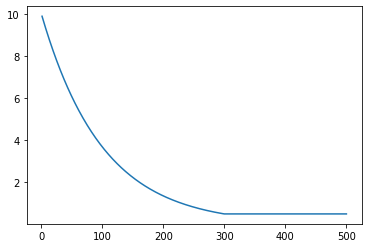

In [9]:
# temparature annealing schedule 
x = [i for i in range(1, 501)]
y = [np.maximum(10 * np.exp(-0.01 * i), 0.5) for i in x]
plt.plot(x, y)
plt.show()


# Main

In [13]:
## %%capture cap --no-stderr
num_layers = 5
hidden = 64
num_hops = 2
batch_size = 50
ratio = 0.05
dropout = False
Net =  DiffPool 
initial_temp = 10
annealing_rate = 0.01
lower_bound = 0.5
hard = True
aux_loss = False
agg = 'max'
alpha1 = 1
alpha2 = 0
alpha3 = 0
lr_base = 1e-6
lr = 1e-4
decay_rate = 1

def logger(info):
    epoch = info['epoch']
    train_loss, train_acc = info['train_loss'], info['train_acc']
    output = '{:03d}: Train Loss: {:.4f}, Train Accuracy: {:.3f}'\
              .format(epoch, train_loss, train_acc)
    return output

dir_path = './data'+ '/' + 'DiffPool_gs_bs50_r005_joint'+ '/' + 'gumbel2_5-max-hard-max' + '/'
# dir_path = './data' + '/' + 'DiffPool_gs_bs50_r005_joint'+ '/' + 'gumbel1_5-avg-hard' + '/'
hyperparams_name = 'hyperparams.pickle'


if os.path.exists(dir_path + hyperparams_name):
    with open(r'{}'.format(dir_path + hyperparams_name), 'rb') as handle:
        hyperparams = pickle.load(handle)
        num_layers = hyperparams['# of layers']
        hidden = hyperparams['# of hidden units']
        num_hops = hyperparams['# of hops']
        batch_size = hyperparams['batch size']
        ratio = hyperparams['pooling ratio']
        dropout = hyperparams['dropout']
        num_patches = hyperparams['# of patches']


else:
    lines = ['-----\{}'.format(Net.__name__)]
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    lines.append('Num of Layers: {}, Num of Hidden Units: {}, Num of Hops: {}, Batch Size: {}, ' \
                 'Pooling Ratio: {}, Dropout: {}, Num of Patches: {}, Total Patches: {}, ' \
                 'Initial temperature: {}, Annealing Rate: {}, Lower Bound: {}, ' \
                 'Auxiliary Loss: {}, Alpha1: {}, Alpha2: {}, Alpha3: {}, ' \
                 'Base Learning Rate: {}, Learning Rate: {}, Decay Rate: {}, hard:{}'
                 .format(num_layers, hidden, num_hops, batch_size, ratio, dropout, num_patches, total, \
                         initial_temp, annealing_rate, lower_bound, aux_loss, \
                         alpha1, alpha2, alpha3, lr_base, lr, decay_rate, hard))
    dataset = dataset_dict['gumbel2_5']
    model = Net(dataset, num_layers, hidden, hop=num_hops, num_patches=num_patches, ratio=ratio, dropout=dropout, \
            total=total, hard_train=hard, aux_loss=aux_loss, agg=agg, decay_rate=decay_rate)
    # !!! load pre-trainined parameters
    orig_dir_path = './data/DiffPool_diff_pool6_max_bs50/gumbel2_5/'
    params_name = 'params_epoch200.pt'
    state = model.state_dict()
    params = torch.load(orig_dir_path+params_name, map_location=device)
    state.update(params)
    model.load_state_dict(state)
    
    process_lines = \
    run(
        dataset,
        model,
        initial_temp,
        total,
        annealing_rate,
        lower_bound,
        epochs=500,
        batch_size=batch_size,
        lr_base=lr_base,
        lr=lr,
        lr_decay_factor=0.5,
        lr_decay_step_size=50,
        weight_decay=0,
        logger=logger,
        aux_loss=aux_loss,
        alpha1=alpha1,
        alpha2=alpha2,
        alpha3=alpha3
    )
    lines += process_lines

    hyperparams = {'# of layers': num_layers, '# of hidden units': hidden, '# of hops': num_hops, \
                   'batch size': batch_size, 'pooling ratio': ratio, 'dropout':dropout, '# of patches': num_patches}

    with open(r'{}'.format(dir_path + hyperparams_name), 'wb') as handle:
        pickle.dump(hyperparams, handle, protocol=pickle.HIGHEST_PROTOCOL)
    now = datetime.now()
    date_time = now.strftime("%Y-%m-%d_%H-%M")
    filename = 'log_' + date_time + '.txt'
    logfile = open(dir_path + filename, 'w')
    for line in lines:
        logfile.write("{}\n".format(line))
    logfile.close()
    
